# Cookie Cats Retention A/B Test Analysis

---


### Executive summary
A/B testing whether moving the first gate from level 30 to level 40 affects retention and engagement.

- **Primary metric (Day-7 retention)**  
  - Control rate (`gate_30`): 19.02% 
  - Treatment rate (`gate_40`): 18.20%
  - Δ = -0.82 pp with 95% CI [-1.33, -0.31], p-value = 0.0016, relative change = -4.31%, Cohen's _h_ = 0.02
- **Decision rule:** Pre-specified MDE = 1.0 pp at α = 0.05.  
- **Outcome:** Fail, result is statistically significant but does not meet the MDE threshold (on the contrary, it harms retention). Guardrail results do not indicate significance. 

**Conclusion:** Based on the pre-specified criteria, the gate move to level 40 **is not recommended** for rollout.

### Project description

Cookie Cats is a mobile puzzle game developed by Tactile Entertainment. The game involves "gates" that serve as intentional breaks between levels, a system typical to puzzle games that boosts player enjoyment and play duration. In this project I will test whether moving the gate from level 30 to level 40 has a significant effect on player retention at day 7, using retention at day 1 and engagement as guardrail metrics. 

Dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats).

`cookie_cats.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `userid` | `int` | Unique player ID |
| `version` | `str` | Experiment split (``gate_30`` = control, ``gate_40`` = treatment) |
| `sum_gamerounds` | `int` | Total rounds per player |
| `retention_1` | `bool` | Active 1 day after installing the game |
| `retention_7` | `bool` | Active 7 days after installing the game |

Each row corresponds to 1 user.

I pre-specified day-7 retention as the primary metric, while specifying day-1 retention and game rounds as guardrails used diagnostically to catch unintended harmful effects.

**Primary metric:** Day-7 retention (``retention_7``).  
**Test applied:** Two-proportion z-test (α = 0.05, two-sided).  
**Power/MDE:** Target 80% power, operational MDE = 1.0 pp.  

- **H₀:** Gate move has no effect on D7 retention.
- **H₁:** Gate move changes D7 retention.

**Guardrails (diagnostic):**
- **Day-1 retention (``retention_1``):** z-test (same structure as primary).
- **Game rounds (``sum_gamerounds``):** Mann–Whitney U (non-parametric) and Welch's t-test on log-transformed data.
  - **H₀:** Distributions are equal across groups.

**Multiple testing:** Guardrail p-values corrected based on Holm method.

**Decision rule:** Rollout only if
- D7 is significant (_p_ < 0.05) AND uplift ≥ 1.0 pp. 
- Otherwise, fail or flag for review.

**Population:** Control (``gate_30``) and treatment (``gate_40``) players

**Sanity checks (Sample Ratio Test):**
- Chi-square test

In [1]:
# Success criteria
primary_metric = "retention_7"  # day-7 retention
guardrail_metrics = [
    "retention_1",
    "sum_gamerounds",
]  # day-1 retention and sum of game rounds per player
alpha = 0.05  # 5% significance level
confidence_level = 1 - alpha  # 95% confidence level
power = 0.80  # 80% statistical power
mde_pp = 1.0  # pre-specified absolute uplift threshold in percentage points

### 1. Experiment setup

In [2]:
# Imports
from cookiecats.io import load_cookiecats
import cookiecats.plots as ccp
import cookiecats.stats as ccs
from cookiecats.tables import build_results_table
import numpy as np
import pandas as pd

### 2. Load data & quick inspection

In [3]:
cookie_df = load_cookiecats()
cookie_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
cookie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
cookie_df.groupby("version")["userid"].nunique()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

Experiment split:
- Control (`gate_30`): 44,700 players
- Treatment (`gate_40`): 45,489 players

### 3. Data cleaning & sanity checks

#### 3.1 Type conversions

Converting boolean values in retention columns to 1 and 0 for easier calculation.

In [6]:
# Convert retention values from boolean to integer
cookie_df[["retention_1", "retention_7"]] = cookie_df[
    ["retention_1", "retention_7"]
].astype(int)
cookie_df[["retention_1", "retention_7"]].head()

,retention_1,retention_7
0,0,0
1,1,0
2,1,0
3,0,0
4,1,1


#### 3.2 Missing values & duplicates

In [7]:
# Missing values per column
missing_values = cookie_df.isnull().sum()
print(f"Missing values per column: \n{missing_values}")

Missing values per column: 
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [8]:
# Check unique users and duplicates
unique_users = cookie_df["userid"].nunique()
duplicate_users = cookie_df[cookie_df.duplicated("userid", keep=False)]

print(f"Unique users: {unique_users}")
print(f"Duplicate users: {duplicate_users['userid'].unique()}")

Unique users: 90189
Duplicate users: []


Records correspond to 90,189 unique players, and there are no missing values in any column.

#### 3.3 Outliers

Exploring outliers in ``sum_gamerounds`` distribution.

In [9]:
# Inspect top players with highest game rounds
cookie_df.sort_values("sum_gamerounds", ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1


**Note:**   
49,854 game rounds is physically impossible, this value is possibly not a naturally ocurring outlier but due to a data integrity error. The remaining top values are in the 2-3k range, indicating extreme player engagement (within normal constraints). I decided to remove the 50k row and use the filtered dataset (``plot_df``) only for the relevant plots on engagement so that they are better interpretable. The sanity checks and tests use the main dataset (``cookiecats_df``) and thus remain unaffected by this action.

In [10]:
# Drop the anomalous value
plot_df = cookie_df[cookie_df["sum_gamerounds"] < 3000].copy()
plot_df.sort_values("sum_gamerounds", ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1
46344,5133952,gate_30,2251,1,1


#### 3.5 Assignment counts & Sample Ratio Test

Conduct a sanity check for sample ratio mismatch (SRM) between versions ``gate_30`` (control group) and ``gate_40`` (treatment group).

In [11]:
# Assign unique player counts to variables
control_players = cookie_df[cookie_df["version"] == "gate_30"]["userid"].nunique()
treatment_players = cookie_df[cookie_df["version"] == "gate_40"]["userid"].nunique()

# Implement chi-square test for SRM
srm_result = ccs.test_srm_chi2(control_players, treatment_players)

# Print SRM results
print(f"SRM (chi-square) p = {srm_result[0]:6f}")
print(
    f"Allocation ratio: control = {control_players} ({srm_result[1]:.2%}), treatment = {treatment_players} ({srm_result[2]:.2%})"
)

if srm_result[0] < 0.001:
    print("Strong SRM indication")
else:
    print("No strong SRM indication")

SRM (chi-square) p = 0.008608
Allocation ratio: control = 44700 (49.56%), treatment = 45489 (50.44%)
No strong SRM indication


### 4. Exploratory data analysis (EDA)

#### 4.1 Summary statistics

Mean, count, and standard deviation summary

In [12]:
# Retention summary statistics
cookie_df.groupby("version")[["retention_1", "retention_7"]].agg(
    ["mean", "std", "count"]
)

retention_1                  retention_7                 
               mean       std  count        mean       std  count
version                                                          
gate_30    0.448188  0.497314  44700    0.190201  0.392464  44700
gate_40    0.442283  0.496663  45489    0.182000  0.385849  45489

In [13]:
# Game rounds summary statistics
agg = cookie_df.groupby("version").agg(
    mean=("sum_gamerounds", "mean"),
    std=("sum_gamerounds", "std"),
    count=("sum_gamerounds", "count"),
)

agg[["mean", "std"]] = agg[["mean", "std"]].round(2)
agg["count"] = agg["count"].astype(int)
agg

,mean,std,count
version,,,
gate_30,52.46,256.72,44700
gate_40,51.30,103.29,45489


#### 4.2 Assignment bar plot

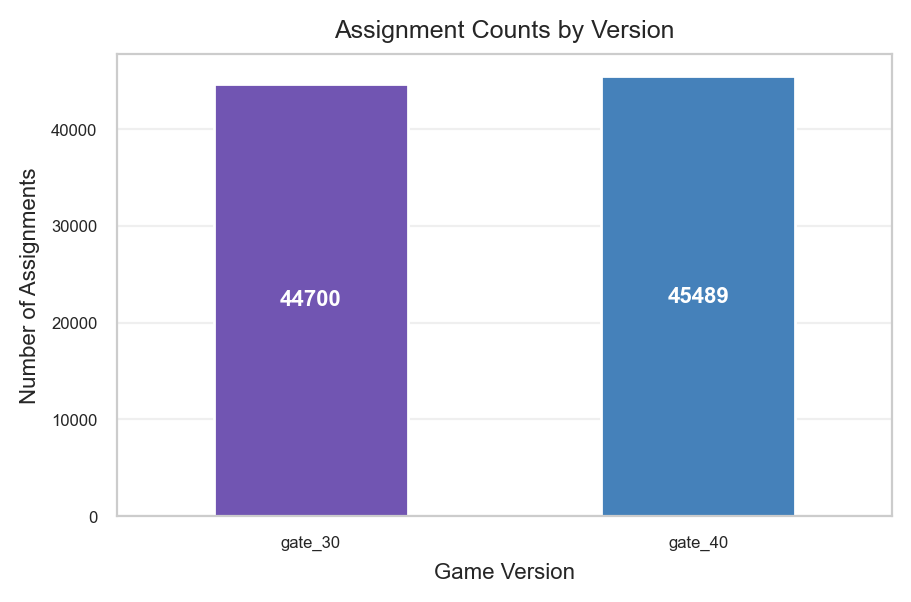

In [14]:
# Plot assignment counts by version
ccp.plot_assignment_counts(cookie_df)

#### 4.3 Retention rates (day-1 and day-7) with 95% CI

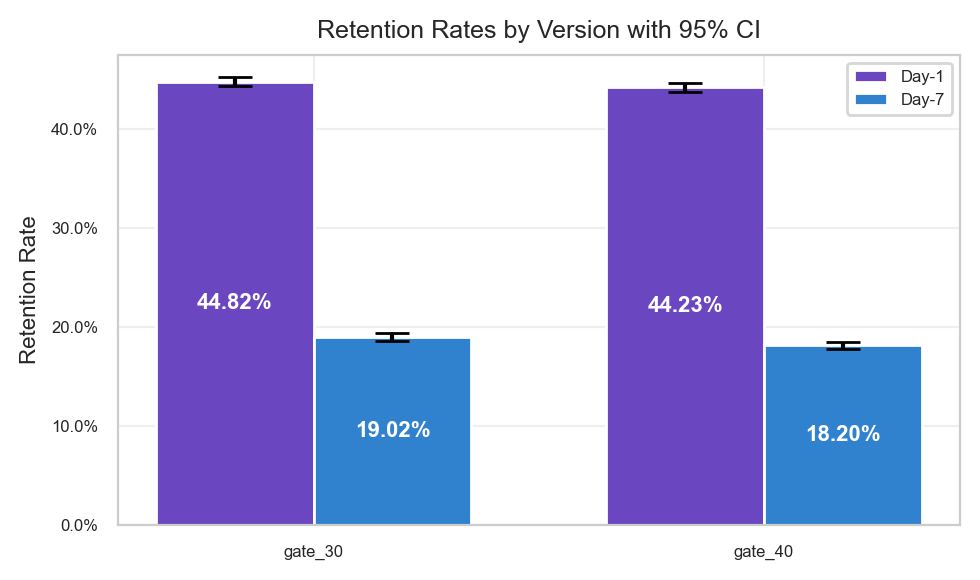

In [15]:
# Plot retention rates by version with 95% CI
ccp.plot_retention_rates(cookie_df)

#### 4.4 Game rounds distribution

In [16]:
# Inspect game rounds distribution
percentiles = cookie_df["sum_gamerounds"].describe(
    percentiles=[0.5, 0.9, 0.95, 0.99, 0.999]
)
print(percentiles)
# IQR method
Q1 = cookie_df["sum_gamerounds"].quantile(0.25)
Q3 = cookie_df["sum_gamerounds"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check outliers
outliers = cookie_df[
    (cookie_df["sum_gamerounds"] < lower_bound)
    | (cookie_df["sum_gamerounds"] > upper_bound)
]
print(
    f"Outliers detected: {len(outliers)} rows ({len(outliers) / len(cookie_df):.2%} of dataset)"
)

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
50%         16.000000
90%        134.000000
95%        221.000000
99%        493.000000
99.9%     1073.624000
max      49854.000000
Name: sum_gamerounds, dtype: float64
Outliers detected: 10177 rows (11.28% of dataset)


Percentiles of 90k unique players display that:
- Player activity is heavily skewed. Half of new players complete less than 16 rounds (median), but a small group plays hundreds to several thousands.
- The right tail lifts the average to 52 rounds, with an ~11% of outliers signaling high engagement.

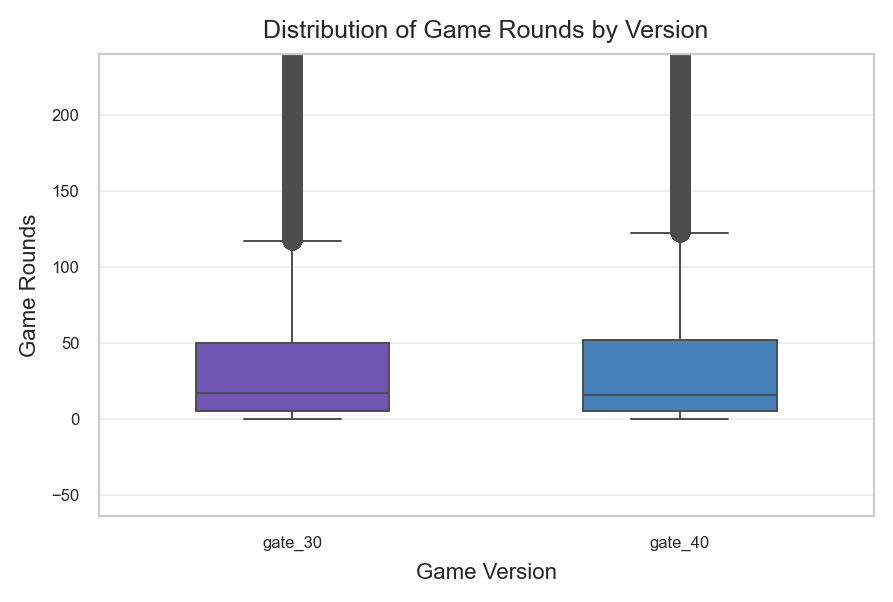

In [17]:
# Plot the distribution of game rounds by version
ccp.plot_game_rounds(plot_df, lower_bound=lower_bound, upper_bound=upper_bound)

On the raw scale, heavy skew disrupts the visuals. Transforming game rounds into log scale is useful for normalizing distribution.

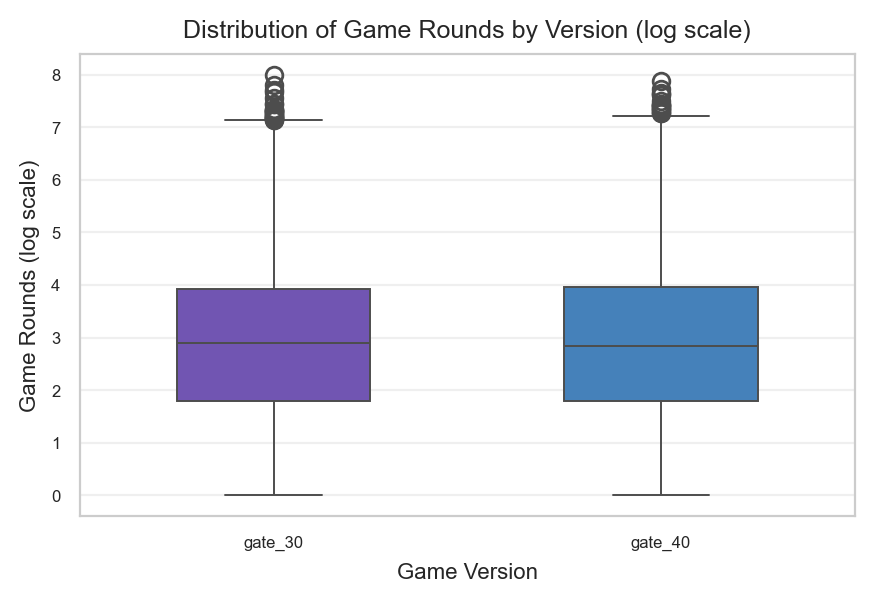

In [18]:
# Create a column to log-transform sum_gamerounds
plot_df.loc[:, "log_sum_gamerounds"] = np.log1p(plot_df["sum_gamerounds"])

# Plot the log-transformed distribution of game rounds by version
ccp.plot_game_rounds(plot_df, lower_bound=lower_bound, upper_bound=upper_bound, log=True)

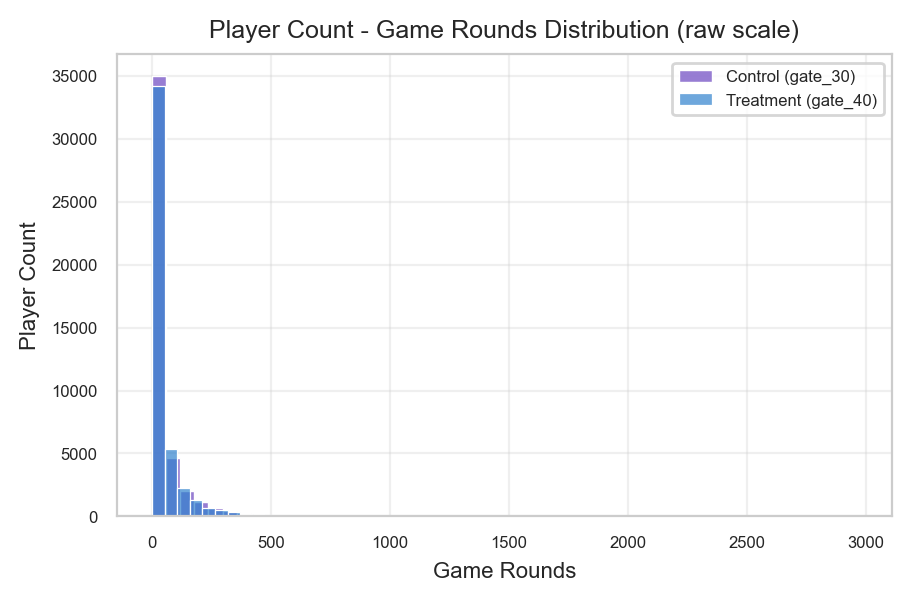

In [19]:
# Plot histogram for player count - game rounds distribution
ccp.plot_game_rounds_dist(plot_df)

~99% of players complete less than 500 rounds. The skew is so heavy that the right tail of the histogram is not visible on the raw scale plot. 

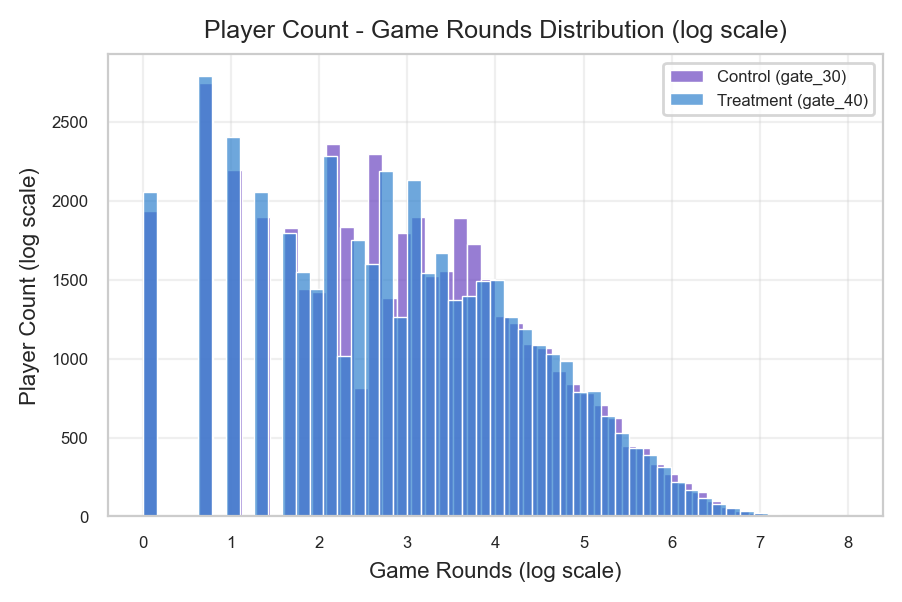

In [20]:
# Plot log-transformed histogram for player count - game rounds distribution
ccp.plot_game_rounds_dist(plot_df, log=True)

Log-transformation shrinks the extreme values so the distribution looks more normal, though it is still skewed to the right.

### 5. Power analysis & MDE exploration

**Minimum Detectable Effect at current sample size**

The experiment pre-specified a target MDE of 1.0 pp at 80% power and 5% alpha. Current sample size should be checked to ensure the experiment can achieve it.

In [21]:
# Baseline p0 (control group day-7 retention)
p0 = cookie_df[cookie_df["version"] == "gate_30"]["retention_7"].mean()

mde_result = ccs.solve_mde(
    cookie_df,
    alpha=alpha,
    power=power,
    p0=p0
)

print(
    f"MDE at current N ({mde_result[0]}) (80% power, two-sided alpha=0.05): {mde_result[1]:.4f} pp"
)

MDE at current N (44700) (80% power, two-sided alpha=0.05): 0.7409 pp


At the current sample size (44,700), any true effect ≥ 0.74 pp can be detected with 80% power. The experiment is over-powered and detects a smaller effect than the designated MDE.

Required samples sizes per group for target MDEs

In [22]:
required_n_result = ccs.solve_required_n(
    alpha=alpha,
    power=power,
    p0=p0
)

required_n_result

,Target MDE (pp),Required N per group
0,0.5,97679
1,0.8,38380
2,1.0,24658
3,1.5,11063
4,2.0,6281


Power vs. MDE plot

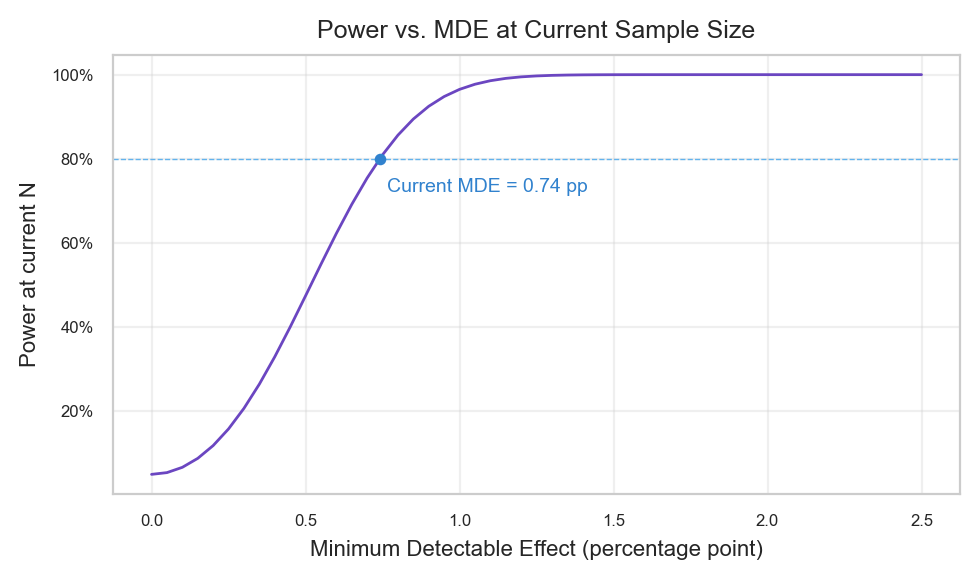

In [23]:
ccp.plot_power_vs_mde(
    p0=p0,
    nob=mde_result[0],
    alpha=alpha,
    mde_pp_current=mde_result[1]
)

The curve crosses 80% power near the computed MDE (0.74 pp) at the current sample size.

MDE vs. N per group plot (balanced at 80% power)

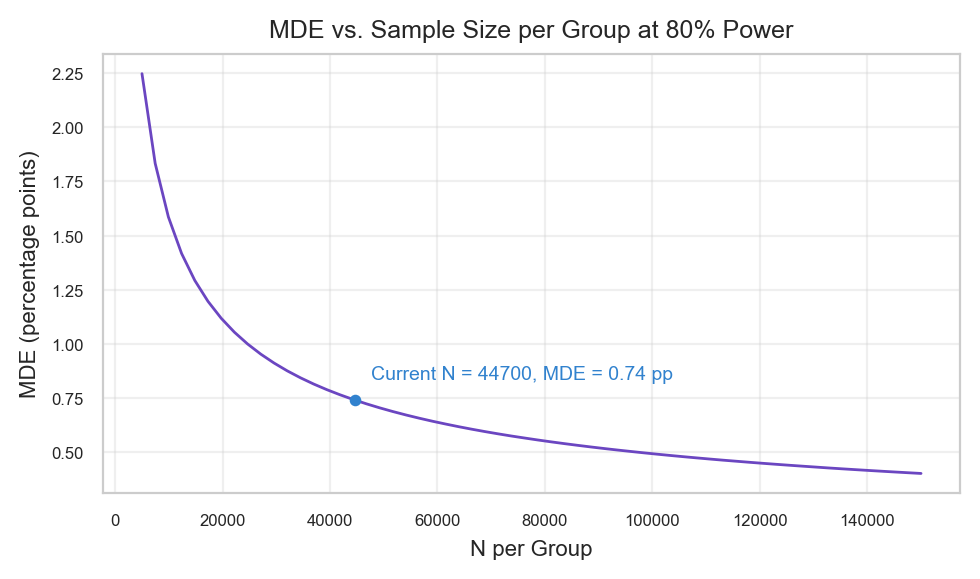

In [24]:
ccp.plot_mde_vs_sample(
    p0=p0,
    alpha=alpha,
    power=power,
    n=mde_result[0],
    mde_pp_current=mde_result[1]
)

MDE targets achievable at the required sample sizes

#### Interpretation

While the experiment design aims for 80% power with 1.0 pp MDE, at the current sample size the experiment can detect a more sensitive MDE of 0.74 pp.

### 6. Primary metric analysis: day-7 retention

In [25]:
ret7_results = ccs.test_two_prop_z(
    df=cookie_df,
    ctrl=control_players,
    treat=treatment_players,
    col="retention_7",
    alpha=alpha,
    p0=p0
)

# Print day-7 retention test results
print(f"gate_30 size: {control_players}")
print(f"gate_40 size: {treatment_players}")
print(
    f"Control group (gate_30) day-7 retention rate: {ret7_results[0]:.6f} (95% CI [{ret7_results[1]:.6f}, {ret7_results[2]:.6f}])"
)
print(
    f"Treatment group (gate_40) day-7 retention rate: {ret7_results[3]:.6f} (95% CI [{ret7_results[4]:.6f}, {ret7_results[5]:.6f}])"
)
print(f"z = {ret7_results[6]:.6f}, p-value = {ret7_results[7]:.6f}")
print(
    f"Absolute difference: {ret7_results[8]:.6f} pp (95% CI [{ret7_results[9] * 100:.3f}, {ret7_results[10] * 100:.3f}] pp)"
)
print(f"Relative difference: {ret7_results[11]:.2f}%")
print(f"Effect size (Cohen's h): {ret7_results[12]:.6f}")

gate_30 size: 44700
gate_40 size: 45489
Control group (gate_30) day-7 retention rate: 0.190201 (95% CI [0.186590, 0.193866])
Treatment group (gate_40) day-7 retention rate: 0.182000 (95% CI [0.178481, 0.185573])
z = 3.164359, p-value = 0.001554
Absolute difference: -0.820130 pp (95% CI [-1.328, -0.312] pp)
Relative difference: -4.31%
Effect size (Cohen's h): 0.021074


#### Interpretation

_p_ < 0.05 indicates statistical significance, meaning that there is indeed a difference between gate level versions. The effect is -0.82 pp, which is lower than the pre-specified MDE of 1.0 pp, but Cohen's _h_ = 0.02 indicates a small effect size. In other words, the treatment (``gate_40``) hurts retention relative to control (``gate_30``), albeit in a negligible magnitude.

### 7. Guardrail metrics analyses: day-1 retention & game rounds

#### 7.1 Day-1 retention

In [27]:
ret1_results = ccs.test_two_prop_z(
    df=cookie_df,
    ctrl=control_players,
    treat=treatment_players,
    col="retention_1",
    alpha=alpha,
    p0=p0
)

# Print day-1 retention test results
print(f"gate_30 size: {control_players}")
print(f"gate_40 size: {treatment_players}")
print(
    f"Control group (gate_30) day-1 retention rate: {ret1_results[0]:.6f} (95% CI [{ret1_results[1]:.6f}, {ret1_results[2]:.6f}])"
)
print(
    f"Treatment group (gate_40) day-1 retention rate: {ret1_results[3]:.6f} (95% CI [{ret1_results[4]:.6f}, {ret1_results[5]:.6f}])"
)
print(f"z = {ret1_results[6]:.6f}, p-value = {ret1_results[7]:.6f}")
print(
    f"Absolute difference: {ret1_results[8]:.6f} pp (95% CI [{ret1_results[9] * 100:.3f}, {ret1_results[10] * 100:.3f}] pp)"
)
print(f"Relative difference: {ret1_results[11]:.2f}%")
print(f"Effect size (Cohen's h): {ret1_results[12]:.6f}")

gate_30 size: 44700
gate_40 size: 45489
Control group (gate_30) day-1 retention rate: 0.448188 (95% CI [0.443582, 0.452802])
Treatment group (gate_40) day-1 retention rate: 0.442283 (95% CI [0.437724, 0.446851])
z = 1.784086, p-value = 0.074410
Absolute difference: -0.590517 pp (95% CI [-1.239, 0.058] pp)
Relative difference: -1.32%
Effect size (Cohen's h): -0.552537


##### Interpretation

Indicated by a large _p_ = 0.074410, there may be no statistically significant difference between experiment groups in day-1 retention.

#### 7.2 Game rounds

Heavy-tailed game rounds data is not appropriate for tests that assume normality. Instead, non-parametrics tests or log-transforming 

Heavy-tailed (right / positive skew), non-parametric + log-transform

In [ ]:
# Engagement stats and Mann-Whitney U test results
engagement_stats = ccs.calculate_engagement_stats(cookie_df)
rounds_results = ccs.test_game_rounds(engagement_stats)

print(f"Control (gate_30) mean: {engagement_stats[2]:.2f}, median: {engagement_stats[3]:.2f}")
print(f"Treatment (gate_40) mean: {engagement_stats[4]:.2f}, median: {engagement_stats[5]:.2f}")
print(f"Mann-Whitney U statistic: {rounds_results[0]:.0f}, p-value: {rounds_results[1]:.6f}")
print(f"Absoulute difference in mean game rounds: {engagement_stats[6]:.2f}")

Control (gate_30) mean: 52.46, median: 17.00
Treatment (gate_40) mean: 51.30, median: 16.00
Mann-Whitney U statistic: 1024331250, p-value: 0.050209
Absoulute difference in mean game rounds: -1.16


In [29]:
# Welch's t-test results
print(
    f"Welch's t-test on log-transformed rounds t-statistic = {rounds_results[2]:6f}, p-value = {rounds_results[3]:6f}"
)
print(f"Control (gate_30) log mean = {engagement_stats[7].mean():6f}")
print(f"Treatment (gate_40) log mean = {engagement_stats[8].mean():6f}")

Welch's t-test on log-transformed rounds t-statistic = 1.814246, p-value = 0.069643
Control (gate_30) log mean = 2.888910
Treatment (gate_40) log mean = 2.870742


Bootstrap 95% CI for mean difference

In [30]:
# Bootstrap results for mean difference in game rounds
bootstrap_result = ccs.bootstrap_mean_diff(rounds_ctrl=engagement_stats[0], rounds_treat=engagement_stats[1])

print(f"Mean difference: {bootstrap_result[0]:.2f}")
print(f"Bootstrap 95% CI for mean difference: [{bootstrap_result[1]:.2f}, {bootstrap_result[2]:.2f}]")

Mean difference: -1.16
Bootstrap 95% CI for mean difference: [-1.04, 4.05]


##### Interpretation

Across all three methods (MWU, Welch t, bootstrap CI), results consistently demonstrate:
- No significant difference between ``gate_30`` and ``gate_40`` in game rounds played.
- Effect size is negligible in practice (less than 1–2 rounds out of ~50 average).
- In other words, changing the gate does not affect overall engagement measured by total rounds played.

### 8. Multiple testing correction

In [31]:
# Adjust guardrail p-values using Holm correction
guardrail_adj = ccs.correct_pvals(ret1_results[7], rounds_results[1], rounds_results[3], alpha=alpha)
print(f"Significant tests: {guardrail_adj[0]}")
print(f"Corrected p-values: {guardrail_adj[1]}")

Significant tests: [False False False]
Corrected p-values: [0.15062642 0.15062642 0.15062642]


### 9. Results summary table

In [32]:
results_table = build_results_table(
    ret1_results=ret1_results,
    ret7_results=ret7_results,
    rounds_results=rounds_results,
    bootstrap_result=bootstrap_result,
    guardrail_adj=guardrail_adj,
    engagement_stats=engagement_stats,
    alpha=alpha
)

results_table

,Metric,Control (gate_30),Treatment (gate_40),Absolute Δ (pp/unit),Relative Δ (%),Effect size,Statistic,p-value,Adjusted p-value,Significant?
0,Day-7 retention,"19.02% (95% CI [18.66%, 19.39%])","18.20% (95% CI [17.85%, 18.56%])","-0.82 pp (95% CI [-1.33, -0.31])",-4.31%,Cohen's h = 0.02,z = 3.16,0.0016,None,Yes
1,Day-1 retention,"44.82% (95% CI [44.36%, 45.28%])","44.23% (95% CI [43.77%, 44.69%])","-0.59 pp (95% CI [-1.24, 0.06])",-1.32%,Cohen's h = -0.55,z = 1.78,0.0744,0.150626,No
2,Mann-Whitney U test on game rounds,52.46 (median: 17.00),51.30 (median: 16.00),-1.16,None,None,U = 1024331250,0.0502,0.150626,No
3,Welch's t-test on log-transformed game rounds,2.888910,2.870742,None,None,None,t = 1.81,0.0696,0.150626,No
4,Bootstrap delta mean rounds,52.46,51.30,-1.16,None,None,"95% CI for mean difference: [-1.04, 4.05]",None,None,None


In [33]:
def decide(pval, delta, mde_pp, alpha):
    if pval < alpha:
        if delta >= mde_pp:
            return "Roll out"
        if delta <= -mde_pp:
            return "Do not roll out, treatment harmful beyond MDE"
        return "Significant but below MDE, do not roll out"
    return "No effect, do not roll out."


print("Decision:", decide(pval=ret7_results[7], delta=ret7_results[7], mde_pp=mde_result[1], alpha=alpha))

Decision: Significant but below MDE, do not roll out


### 10. Business impact projection

In [34]:
# Calculate the number of retained players at Day-7 per 100,000 new players
def calculate_impact(ret7_results, K, ARPU_7):
    # Calculate the number of retained players at Day-7 per K new players
    retained_players = K * (ret7_results[3] - ret7_results[0])
    
    # Calculate the approximate revenue impact per K new players
    revenue_impact = retained_players * ARPU_7
    
    # Calculate the confidence interval for the difference per K retained players
    delta_ci = (K * ret7_results[9], K * ret7_results[10])

    return retained_players, revenue_impact, delta_ci

K = 100_000
ARPU_7 = 0.50
business_projection = calculate_impact(ret7_results, K=K, ARPU_7=ARPU_7)
print(
    f"Retained players at Day-7 per {K:,} new players: {business_projection[0]:.0f} [{business_projection[2][0]:.0f}, {business_projection[2][1]:.0f}]"
)

# Calculate the approximate revenue impact per 100,000 new players
print(f"Approximate revenue impact per {K:,} players: ${business_projection[1]:.0f}")

Retained players at Day-7 per 100,000 new players: -820 [-1328, -312]
Approximate revenue impact per 100,000 players: $-410


### 11. Conclusion
- **Primary Metric**: Moving the gate from level 30 to level 40 **reduces Day-7 retention by 0.82 percentage points**
- **Statistical Significance**: Highly significant (p = 0.0016)
- **Effect**: Below the pre-specified MDE threshold of 1.0 percentage points

**Decision:**
**Do not roll out** the treatment. While the effect is statistically significant, it fails to meet the business threshold for implementation and actually harms retention.

#### 11.1 Limitations & next steps

- **No timestamps in dataset:** cannot perform time-to-event analysis.
- **No covariates:** cannot adjust for potential confounding or run subgroup analysis.
- **No exposure flag:** results are population estimates, effect may be diluted if many users never reach the gate.
- **No revenue data:** business-impact projection is illustrative and requires real ARPU values.

In [35]:
# Save the results tables to a CSV file
# results_table.to_csv(r"reports/results_table.csv", index=False)
# exp_sens_df.to_csv(r"reports/exposure_sensitivity.csv", index=False)